# Section Project:

For the final project for this section, you're going to train on the MNIST dataset using federated learning However the gradient should not come up to central server in raw form

In [1]:
import numpy as np
import torch as th
from torchvision import datasets,transforms
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import syft as sy
hook = sy.TorchHook(th)

In [2]:
bob = sy.VirtualWorker(hook,id="bob")
alice = sy.VirtualWorker(hook,id="alice")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the train and test data by using the transform
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [4]:
num_workers = 2
batch_size = 32
teacher_loaders = []
data_size = len(train_data)//num_workers
alices_indices = list(range(0,data_size))
bobs_indices = list(range(data_size+1, data_size*num_workers))
alices_data = Subset(train_data,alices_indices)
alices_loader = th.utils.data.DataLoader(alices_data, batch_size = batch_size,shuffle=True)
bobs_data = Subset(train_data,bobs_indices)
bobs_loader = th.utils.data.DataLoader(bobs_data, batch_size = batch_size,shuffle=True)

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,64)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer with softmax activation
        x = F.log_softmax(self.output(x),dim=1)
        
        return x
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


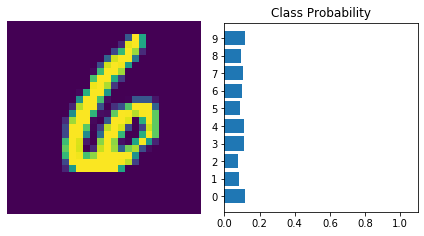

In [6]:
%matplotlib inline
import helper
images, labels = next(iter(alices_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with th.no_grad():
    logps =model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities

ps = th.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [7]:
num_rounds = 5
n_epochs = 1
bobs_criterion = nn.NLLLoss().send(bob)
alices_criterion = nn.NLLLoss().send(alice)

for round_iter in range(num_rounds):
    print("Round: " + str(round_iter))
    bobs_model = model.copy().send(bob)
    alices_model = model.copy().send(alice)
    
    bobs_opt = optim.SGD(params= bobs_model.parameters(), lr = 0.1)
    alices_opt = optim.SGD(params = alices_model.parameters(),lr = 0.1)
    b_running_loss = 0
    a_running_loss = 0
    for i in range(n_epochs):
        #print("Epoch Number: " + str(i))
        for images,labels in bobs_loader:
            bobs_opt.zero_grad()
            images = images.view(images.shape[0], -1)
            bobs_pred = bobs_model(images.send(bob))
            bobs_loss = bobs_criterion(bobs_pred,labels.send(bob))
            bobs_loss.backward()
        
            bobs_opt.step()
            bobs_loss= bobs_loss.get().data
            b_running_loss += bobs_loss
        else:
            print(f" Bobs Training loss: {b_running_loss/len(bobs_loader)}")
        for images, labels in alices_loader:
            alices_opt.zero_grad()
            images = images.view(images.shape[0], -1)
            alices_pred = alices_model(images.send(alice))
            alices_loss = alices_criterion(alices_pred,labels.send(alice))
            alices_loss.backward()
        
            alices_opt.step()
            alices_loss= alices_loss.get().data
            a_running_loss += alices_loss
        else:
            print(f" Alices Training loss: {a_running_loss/len(alices_loader)}")
    
    alices_model.move(bob)
    with th.no_grad():
        bobs_model.fc1.weight.set_(((alices_model.fc1.weight.data + bobs_model.fc1.weight.data)/2))
        bobs_model.fc1.bias.set_(((alices_model.fc1.bias.data + bobs_model.fc1.bias.data)/2))
        bobs_model.fc2.weight.set_(((alices_model.fc2.weight.data + bobs_model.fc2.weight.data)/2))
        bobs_model.fc2.bias.set_(((alices_model.fc2.bias.data + bobs_model.fc2.bias.data)/2))
        bobs_model.output.weight.set_(((alices_model.output.weight.data + bobs_model.output.weight.data)/2))
        bobs_model.output.bias.set_(((alices_model.output.bias.data + bobs_model.output.bias.data)/2))
    model = bobs_model.get()
    
    #print("Bob: " + str(bobs_loss) + " Alice: " + str(alices_loss))

Round: 0
 Bobs Training loss: 0.5454689264297485
 Alices Training loss: 0.5398927927017212
Round: 1
 Bobs Training loss: 0.21711744368076324
 Alices Training loss: 0.22931382060050964
Round: 2
 Bobs Training loss: 0.16093729436397552
 Alices Training loss: 0.18055693805217743
Round: 3
 Bobs Training loss: 0.13053102791309357
 Alices Training loss: 0.1551971584558487
Round: 4
 Bobs Training loss: 0.10796307027339935
 Alices Training loss: 0.14176616072654724


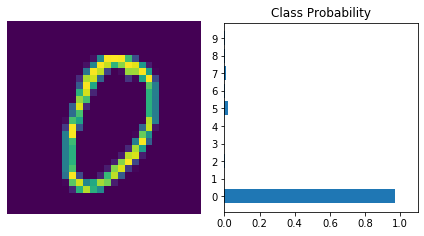

In [8]:
images, labels = next(iter(alices_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with th.no_grad():
    logps =model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities

ps = th.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)